In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

### Load iris dataset and parse data for model training

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
train, test = df[df['is_train']==True], df[df['is_train']==False]

#### Take a peek at _df_

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),is_train,species
0,5.1,3.5,1.4,0.2,True,setosa
1,4.9,3.0,1.4,0.2,True,setosa
2,4.7,3.2,1.3,0.2,True,setosa
3,4.6,3.1,1.5,0.2,True,setosa
4,5.0,3.6,1.4,0.2,True,setosa


### Train a decision tree and print a confusion matrix with the results 

In [4]:
from sklearn.tree import DecisionTreeClassifier

features = df.columns[:4]
clf = DecisionTreeClassifier()
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)
 
preds = iris.target_names[clf.predict(test[features])]
pd.crosstab(test['species'], preds, rownames=['actual'], colnames=['preds'])

preds,setosa,versicolor,virginica
actual,,,
setosa,12,0,0
versicolor,0,10,1
virginica,0,1,6


### Repeat the process but with a Random Forest model this time around 

In [5]:
from sklearn.ensemble import RandomForestClassifier

features = df.columns[:4]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)
 
preds = iris.target_names[clf.predict(test[features])]
pd.crosstab(test['species'], preds, rownames=['actual'], colnames=['preds'])

preds,setosa,versicolor,virginica
actual,,,
setosa,12,0,0
versicolor,0,9,2
virginica,0,1,6


### Performance test of Random Forest, Extra Trees and Decision Tree

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=10000, n_features=10, centers=100, random_state=0)

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print (scores.mean())                             

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print (scores.mean())                             

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print (scores.mean())

0.979408793821
0.999607843137
0.999898989899


### Various ensambles tested on different subsets of features

DecisionTree with features [0, 1] has a score of 0.926666666667
RandomForest with 30 estimators with features [0, 1] has a score of 0.926666666667
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.926666666667
AdaBoost with 30 estimators with features [0, 1] has a score of 0.84
DecisionTree with features [0, 2] has a score of 0.993333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.993333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.993333333333
DecisionTree with features [2, 3] has a score of 0.993333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.993333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.993333333333


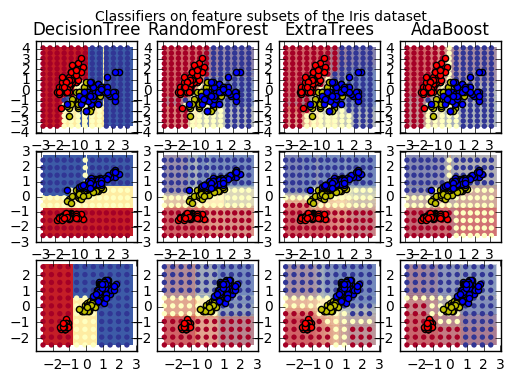

In [7]:
import numpy as np
import pylab as pl

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = pl.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print (model_details + " with features", pair, "has a score of", scores)

        pl.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            pl.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = pl.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = pl.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = pl.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            pl.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                       cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

pl.suptitle("Classifiers on feature subsets of the Iris dataset")
pl.axis("tight")

pl.show()